# Import libraries and setup config

In [10]:
from datetime import datetime, timedelta
import os, sys, time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper")
pd.set_option('display.max_columns', None)
import gzip
import pytz
import networkx as nx
from io import StringIO

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment',None)


In [2]:
df_raw_data = pd.read_csv(f'../../Converted_Datasets/extrasensory_dataset.csv')
df_raw_data.info()
df_raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380031 entries, 0 to 380030
Columns: 105 entries, uuid to With friends_missing
dtypes: bool(102), int64(1), object(2)
memory usage: 45.7+ MB


,uuid,timestamp,Lying down,Sitting,Walking,Running,Bicycling,Sleeping,Lab work,In class,In a meeting,AtWorkplace,Indoors,Outside,In a car,On a bus,Drive - I'm the driver,Drive - I'm a passenger,AtHome,AtRestaurant,Phone in pocket,Exercise,Cooking,Shopping,Strolling,Drinking (alcohol),Bathing - shower,Cleaning,Doing laundry,Washing dishes,WatchingTV,Surfing the internet,At a party,At a bar,AtBeach,Singing,Talking,Computer work,Eating,Toilet,Grooming,Dressing,At the gym,Stairs - going up,Stairs - going down,Elevator,Standing,At school,Phone in hand,Phone in bag,Phone on table,With co-workers,With friends,uuid_missing,Lying down_missing,Sitting_missing,Walking_missing,Running_missing,Bicycling_missing,Sleeping_missing,Lab work_missing,In class_missing,In a meeting_missing,AtWorkplace_missing,Indoors_missing,Outside_missing,In a car_missing,On a bus_missing,Drive - I'm the driver_missing,Drive - I'm a passenger_missing,AtHome_missing,AtRestaurant_missing,Phone in pocket_missing,Exercise_missing,Cooking_missing,Shopping_missing,Strolling_missing,Drinking (alcohol)_missing,Bathing - shower_missing,Cleaning_missing,Doing laundry_missing,Washing dishes_missing,WatchingTV_missing,Surfing the internet_missing,At a party_missing,At a bar_missing,AtBeach_missing,Singing_missing,Talking_missing,Computer work_missing,Eating_missing,Toilet_missing,Grooming_missing,Dressing_missing,At the gym_missing,Stairs - going up_missing,Stairs - going down_missing,Elevator_missing,Standing_missing,At school_missing,Phone in hand_missing,Phone in bag_missing,Phone on table_missing,With co-workers_missing,With friends_missing
0,A7599A50-24AE-46A6-8EA6-2576F1011D81,1446762297,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,A7599A50-24AE-46A6-8EA6-2576F1011D81,False,False,False,True,True,False,True,True,False,False,True,True,False,False,False,True,False,False,True,False,True,False,False,True,False,True,True,True,True,False,True,True,True,True,False,True,False,True,False,False,True,True,True,True,False,False,False,False,False,False,False
1,A7599A50-24AE-46A6-8EA6-2576F1011D81,1446762357,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,A7599A50-24AE-46A6-8EA6-2576F1011D81,False,False,False,True,True,False,True,True,False,False,True,True,False,False,False,True,False,False,True,False,True,False,False,True,False,True,True,True,True,False,True,True,True,True,False,True,False,True,False,False,True,True,True,True,False,False,False,False,False,False,False
2,A7599A50-24AE-46A6-8EA6-2576F1011D81,1446762417,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,A7599A50-24AE-46A6-8EA6-2576F1011D81,False,False,False,True,True,False,True,True,False,False,True,True,False,False,False,True,False,False,True,False,True,False,False,True,False,True,True,True,True,False,True,True,True,True,False,True,False,True,False,False,True,True,True,True,False,False,False,False,False,False,False
3,A7599A50-24AE-46A6-8EA6-2576F1011D81,1446762487,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,A7599A50-24AE-

# Get ontological labels

In [3]:
df_raw_data.columns.tolist()

['uuid',
 'timestamp',
 'Lying down',
 'Sitting',
 'Walking',
 'Running',
 'Bicycling',
 'Sleeping',
 'Lab work',
 'In class',
 'In a meeting',
 'AtWorkplace',
 'Indoors',
 'Outside',
 'In a car',
 'On a bus',
 "Drive - I'm the driver",
 "Drive - I'm a passenger",
 'AtHome',
 'AtRestaurant',
 'Phone in pocket',
 'Exercise',
 'Cooking',
 'Shopping',
 'Strolling',
 'Drinking (alcohol)',
 'Bathing - shower',
 'Cleaning',
 'Doing laundry',
 'Washing dishes',
 'WatchingTV',
 'Surfing the internet',
 'At a party',
 'At a bar',
 'AtBeach',
 'Singing',
 'Talking',
 'Computer work',
 'Eating',
 'Toilet',
 'Grooming',
 'Dressing',
 'At the gym',
 'Stairs - going up',
 'Stairs - going down',
 'Elevator',
 'Standing',
 'At school',
 'Phone in hand',
 'Phone in bag',
 'Phone on table',
 'With co-workers',
 'With friends',
 'uuid_missing',
 'Lying down_missing',
 'Sitting_missing',
 'Walking_missing',
 'Running_missing',
 'Bicycling_missing',
 'Sleeping_missing',
 'Lab work_missing',
 'In class_miss

In [4]:
all_labels = ['Lying down','Sitting', 'Walking', 'Running', 'Bicycling', 'Sleeping', 'Lab work', 'In class', 'In a meeting',
 'AtWorkplace', 'Indoors', 'Outside', 'In a car', 'On a bus', "Drive - I'm the driver", "Drive - I'm a passenger",
'AtHome', 'AtRestaurant', 'Phone in pocket', 'Exercise', 'Cooking', 'Shopping', 'Strolling', 'Drinking (alcohol)',
'Bathing - shower', 'Cleaning', 'Doing laundry', 'Washing dishes', 'WatchingTV', 'Surfing the internet', 'At a party', 
'At a bar', 'AtBeach', 'Singing', 'Talking', 'Computer work', 'Eating', 'Toilet', 'Grooming', 'Dressing', 'At the gym',
 'Stairs - going up', 'Stairs - going down', 'Elevator', 'Standing', 'At school', 'Phone in hand', 'Phone in bag',
'Phone on table', 'With co-workers', 'With friends']


contexts = [
    'housework',
    'dailyroutine',
    'exercising',
    'amusement',
    'sleeping',
    'inactivity',
    'commuting',
    'havingmeal',
    'officework'
]

locations = ['AtWorkplace','AtHome','Indoors','Outside','In a car','On a bus','At a party',
             'AtRestaurant','At a bar','AtBeach','At the gym','Elevator','At school']

phone_locations = ['Phone in pocket', 'Phone in hand', 'Phone in bag','Phone on table']

activities = ['Lying down','Sitting', 'Walking', 'Running', 'Bicycling', 'Sleeping', 'Lab work', 'In class', 
              'In a meeting', "Drive - I'm the driver", "Drive - I'm a passenger", 'Exercise', 'Cooking', 
              'Shopping', 'Strolling', 'Drinking (alcohol)','Bathing - shower', 'Cleaning', 'Doing laundry', 
              'Washing dishes', 'WatchingTV', 'Surfing the internet', 'Singing', 'Talking', 'Computer work', 
              'Eating', 'Toilet', 'Grooming', 'Dressing', 'Stairs - going up', 'Stairs - going down', 'Standing', 
              'With co-workers', 'With friends']

# context_activity_relation = {
#     'housework':['Cooking','Cleaning','Doing laundry','Washing dishes','Standing'],
#     'dailyroutine':['Bathing - shower','Toilet', 'Grooming', 'Dressing','Indoors','Standing'],
#     'exercising':['Walking', 'Running', 'Bicycling','Exercise','Indoors'],
#     'amusement':['Sitting', 'Shopping', 'Strolling', 'Drinking (alcohol)', 'WatchingTV','Singing','With friends','Talking'],
#     'sleeping':['Lying down','Sleeping','Indoors'],
#     'inactivity':['Lying down', 'Sleeping','Indoors','Sitting','Standing'],
#     'commuting':[ "Drive - I'm the driver", "Drive - I'm a passenger", 'Walking', 
#                  'Bicycling','Stairs - going up', 'Stairs - going down','Outside','Sitting','Standing'],
#     'havingmeal':['Eating','Indoors','Sitting'],
#     'officework':['In a meeting', 'With co-workers','Lab work', 'In class','Surfing the internet','Computer work','Indoors','Sitting','Talking']
# }

# context_location_relation = {
#     'housework':['AtHome','Indoors'],
#     'dailyroutine':['AtHome','Indoors'],
#     'exercising':['At the gym','AtHome','Indoors'],
#     'amusement':['AtHome','AtRestaurant','At a bar','AtBeach','At a party','Indoors','Outside'],
#     'sleeping':['AtHome','Indoors'],
#     'inactivity':['AtHome','AtWorkplace','Indoors'],
#     'commuting':['In a car','On a bus','Outside'],
#     'havingmeal':['AtHome','AtWorkplace','AtRestaurant','At a bar','At school','Indoors'],
#     'officework':['AtWorkplace','AtHome','At school','Elevator','Indoors']
# }

# context_phone_location_relation = {
#     'housework':['Phone in bag','Phone on table'],
#     'dailyroutine':['Phone in bag','Phone on table'],
#     'exercising':['Phone in pocket', 'Phone in bag'],
#     'amusement':['Phone in pocket', 'Phone in hand', 'Phone in bag','Phone on table'],
#     'sleeping':['Phone in bag','Phone on table'],
#     'inactivity':['Phone in pocket', 'Phone in bag','Phone on table'],
#     'commuting':['Phone in pocket', 'Phone in hand'],
#     'havingmeal':['Phone in pocket', 'Phone in hand','Phone on table'],
#     'officework':['Phone in pocket', 'Phone in hand', 'Phone in bag','Phone on table']
# }


# A new approach to unknown context detection

## get activity_trains function

In [28]:
def activity_set_id_to_activities(activity_set_id,activities):
    activity_set = []
    assert(len(activities)==len(activity_set_id))
    for i in range(len(activities)):
        if activity_set_id[i]=='1':
            activity_set.append(activities[i])
    if len(activity_set)==0:
        return 'None'
    return ','.join(activity_set) 

def get_activity_train(df_time_data, activity_cols, min_duration = 1,duration_diff = 60*15,duration_max = 60*60*3, 
                       inf_duration = 60*60*60*60, time_col='timestamp',convert_ids=False, get_freq=False): 
    # get activity ids
    df_activities = df_time_data[activities]
    df_activities['activity_set_id'] = df_activities.apply(lambda row: "".join(['1' if xr else '0' for xr in row]),axis=1)
    df_activities['timestamp'] = df_time_data[time_col]                                               
    
    # group activity over time 
    df_activities = df_activities[['timestamp','activity_set_id']]
    df_activities['group'] = df_activities['activity_set_id'].ne(df_activities['activity_set_id'].shift()).cumsum()
    
    df_activity_train = df_activities.groupby(['activity_set_id','group'],as_index=False).agg({'timestamp':['max','min','count']})
    df_activity_train = df_activity_train.sort_values(by='group')
    df_activity_train.columns = ['_'.join(col).strip() for col in df_activity_train.columns.values]
    
    
    # create duration class
    df_activity_train['duration']= df_activity_train['timestamp_max'] - df_activity_train['timestamp_min']
    df_activity_train = df_activity_train[df_activity_train['duration']>=min_duration]
    df_activity_train['max_sampling_space'] = df_activity_train['duration'] / df_activity_train['timestamp_count']
    
    duration_class = list(range(0,duration_max+duration_diff,duration_diff))
    duration_class = np.array(duration_class+[inf_duration])
    df_activity_train['duration_class'] = df_activity_train.duration.apply(lambda x: np.where(duration_class>x)[0][0])
    
    # get final activity, duration_class train
    if convert_ids:
        df_activity_train['activity_set'] =df_activity_train['activity_set_id_'].apply(lambda x: activity_set_id_to_activities(x,activities))
        activity_train = df_activity_train[['activity_set','duration_class']].values.tolist()
    else:
        activity_train = df_activity_train[['activity_set_id_','duration_class']].values.tolist()
        
    if get_freq:
        activity_train = [tuple(x) for x in activity_train]
    else:
        activity_train= [x[0] for x in activity_train]

    return activity_train

    
    
    

## Function for frequency maps

In [29]:
def get_ordered_subset_frequencies(activity_train, lag=2):
    freq_set = pd.Series([tuple(sorted(activity_train[i:i+lag])) for i in range(len(activity_train)-lag)]).value_counts()
    return freq_set.to_dict()

def get_unordered_subset_frequencies(activity_train, lag=2):
    freq_set = pd.Series([tuple(activity_train[i:i+lag]) for i in range(len(activity_train)-lag)]).value_counts()
    return freq_set.to_dict()

    

# Use networkx to create graph from activity train

## get a activity train to work with

In [30]:
sample_uuid = 'A7599A50-24AE-46A6-8EA6-2576F1011D81'
df_uuid_data = df_raw_data[df_raw_data.uuid==sample_uuid]
df_uuid_data.info()
atrain = get_activity_train(df_uuid_data, activities) 
atrain

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3898 entries, 0 to 3897
Columns: 105 entries, uuid to With friends_missing
dtypes: bool(102), int64(1), object(2)
memory usage: 510.1+ KB


['0100000010000000000000010000000000',
 '0010000000000010000000000000000000',
 '0010000000000000000000000000000000',
 '0000000000000000000000000000000100',
 '0100000000000000000000000100000000',
 '0010000000000000000000000000000000',
 '0100000000000000000000000000000000',
 '0010000000000000000000000000000000',
 '0000000000010000000000010000000100',
 '0100000000000000000000000000000000',
 '0100000000000000000000000000000000',
 '0010000000000010000000000000000000',
 '0100000000000000000001000000000000',
 '0000000000000000000000000000000000',
 '0100000000000000000001000000000000',
 '1000010000000000000000000000000000',
 '0000000000000000100000000000000100',
 '0000000000000000000000000001100100',
 '0100000000000000000001000100000000',
 '0100000001000000000000000000000000',
 '0100000001000000000000000000000000',
 '0100000000000000000000000100000000',
 '0100000001000000000000000000000000',
 '0100000000000000000001000000000000',
 '0010000000000000000000000000000000',
 '01000000000000000000000

## Create graph based on activity train

In [164]:
def get_node_id(activity_set,lag):
    node_id = 0
    for i, act_char in enumerate(activity_set[::-1]):
        if act_char=='1':
            node_id += 1<<i
        
    return f"{str(node_id)}_{str(lag)}"

def get_aset_id(node_id):
    act_num_id, lag = node_id.split("_")
    return "{0:b}".format(int(act_num_id)), int(lag)

In [130]:
def create_lagtree(df_time_data, activities, max_lag):
    agraph = nx.DiGraph()
    root_node_id = get_node_id('0'*len(activities),0)
    agraph.add_node(root_node_id)
    atrain = get_activity_train(df_time_data, activities) 
    # agraph.nodes[root_node_id]['wt'] = 0
    for lag in range(1, max_lag+1):
        if lag==1:
            for aset in atrain:
                node_id = get_node_id(aset,lag)
                if node_id not in agraph.nodes:
                    agraph.add_node(node_id)
                    agraph.add_edge(root_node_id, node_id,weight=1)
                else:
                    agraph[root_node_id][node_id]['weight'] +=1
        else:
            atrain_lag_club = [atrain[i:i+lag] for i in range(len(atrain)-lag)]
            for asets in atrain_lag_club:
                prev_node_id = root_node_id
                for j,aset in enumerate(asets):
                    node_id = get_node_id(aset,j+1)
                    if node_id not in agraph.nodes:
                        agraph.add_node(node_id)
                        agraph.add_edge(prev_node_id, node_id,weight=1)
                    else:
                        if tuple([prev_node_id, node_id]) not in agraph.edges:
                            agraph.add_edge(prev_node_id, node_id, weight=1)
                        else:
                            agraph[prev_node_id][node_id]['weight'] +=1
                    prev_node_id = node_id
    return agraph



In [135]:
agraph = create_lagtree(df_uuid_data, activities, 3)

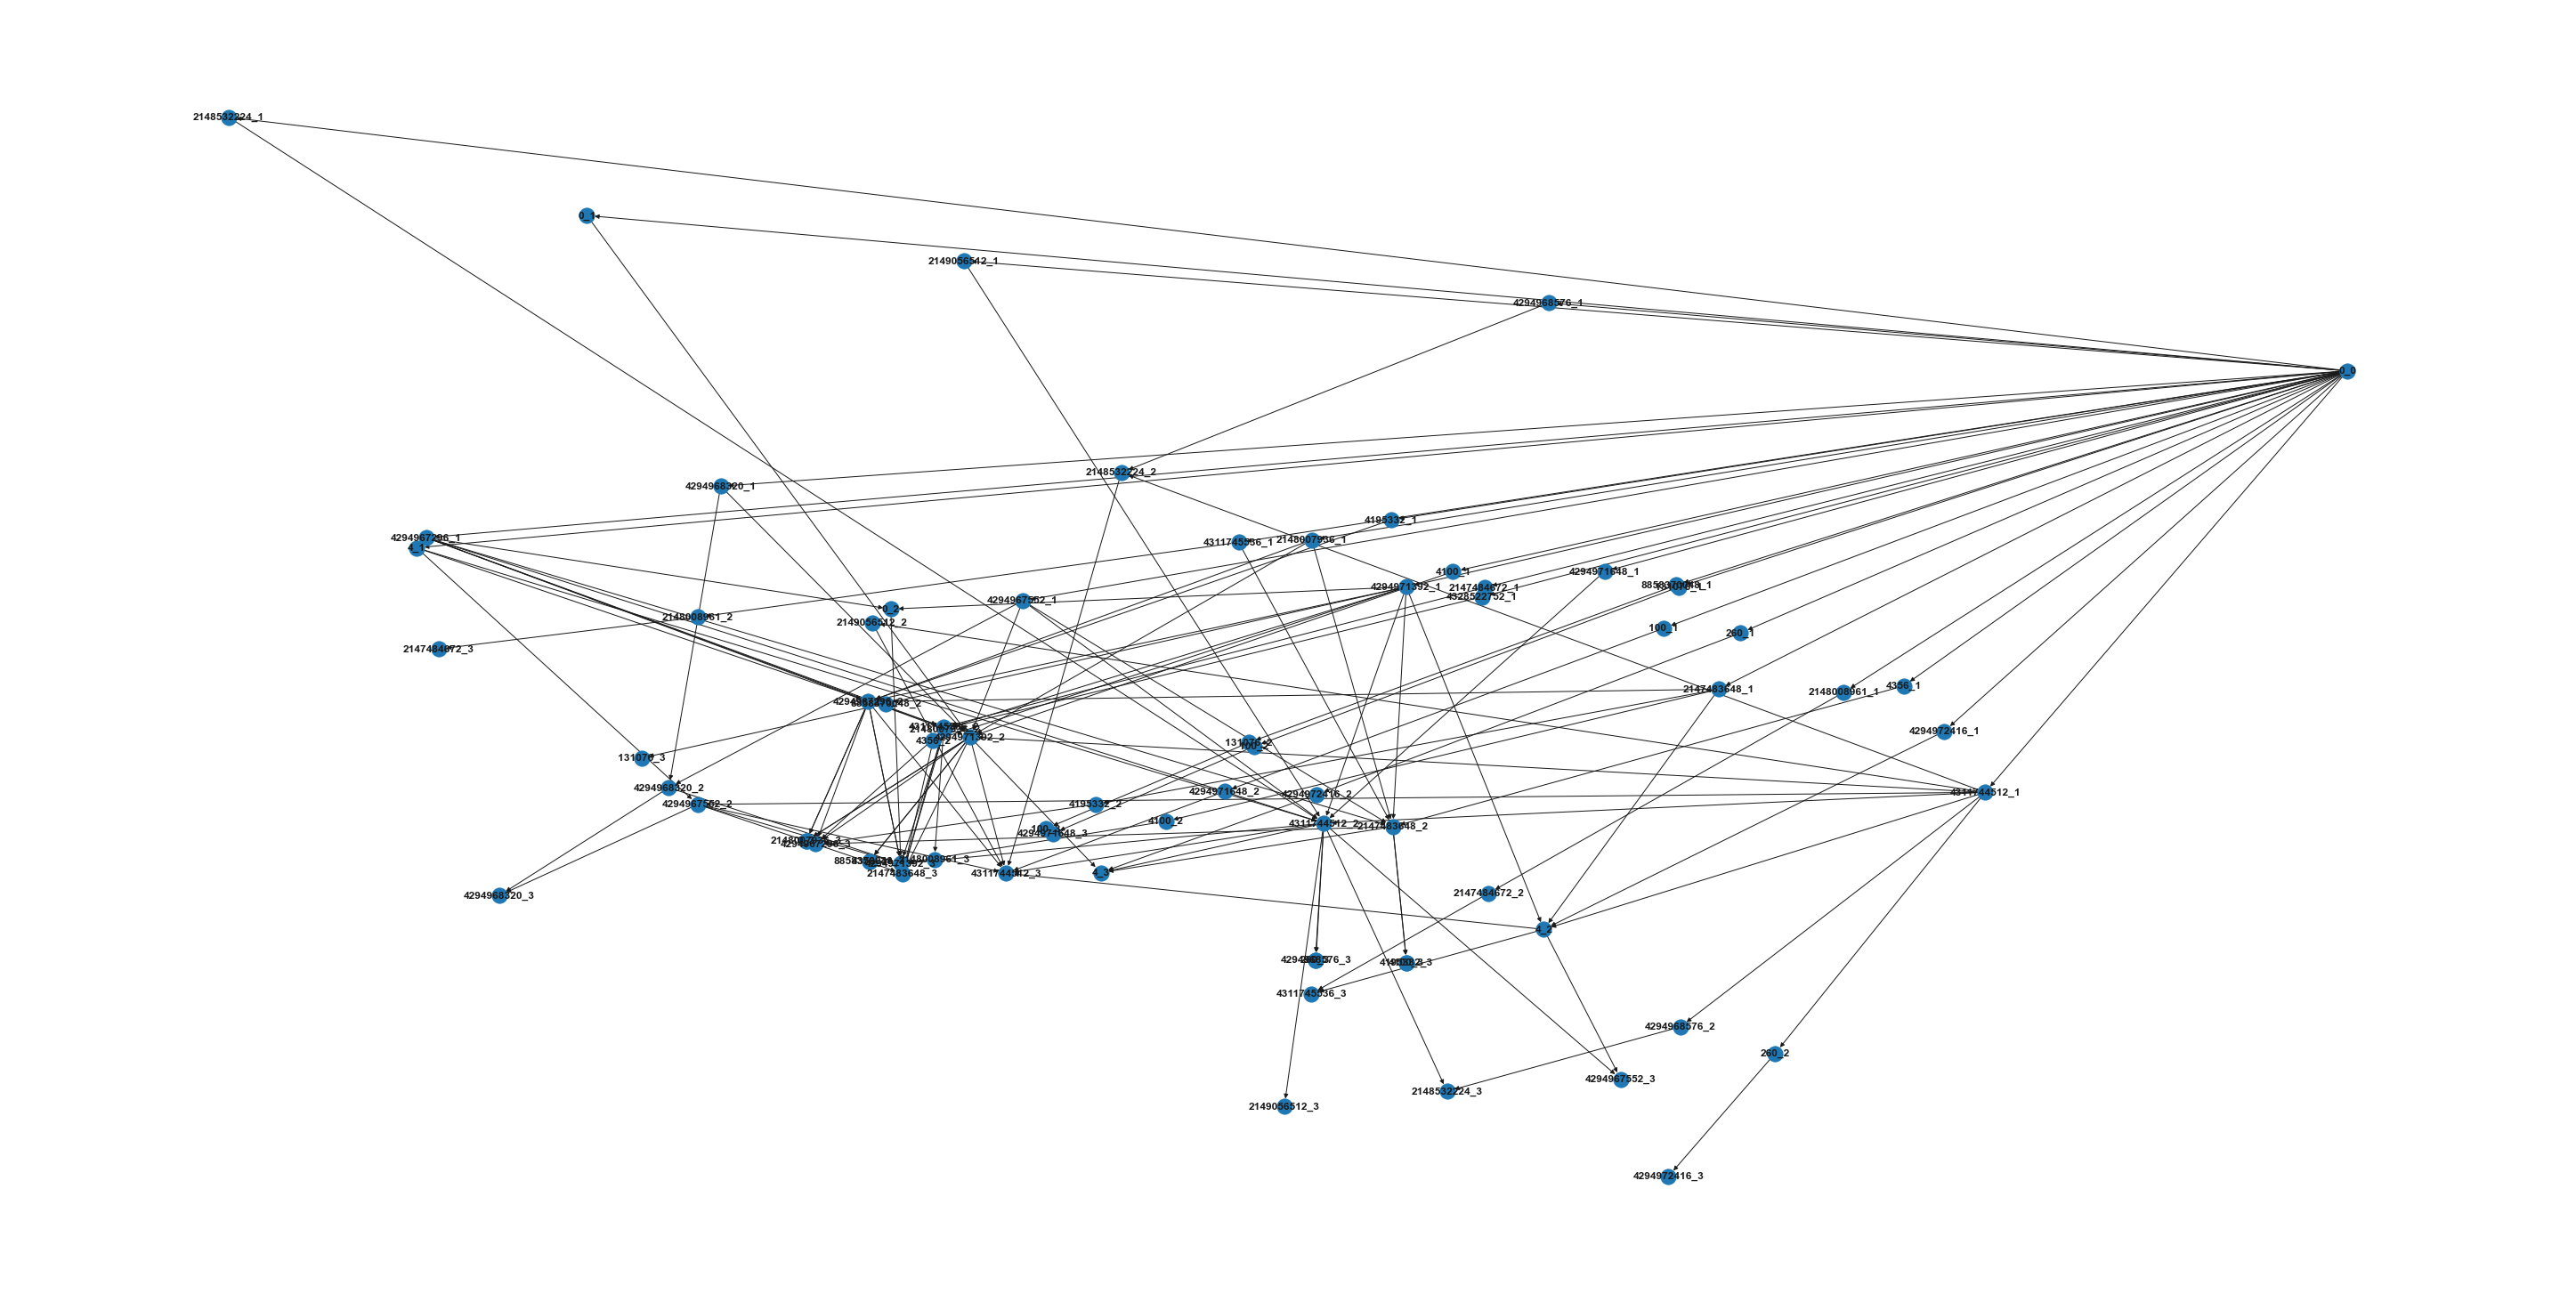

In [162]:
def plot_graph(agraph, layout_func=nx.kamada_kawai_layout,pltsize=(40,20)):
    plt.figure(figsize=pltsize)
    pos = nx.kamada_kawai_layout(agraph)
    nx.draw(agraph, pos=pos, with_labels=True, font_weight='bold')
plot_graph(agraph)

In [158]:
for edge in agraph.edges.data():
    print(edge)

('0_0', '4328522752_1', {'weight': 3})
('0_0', '2148007936_1', {'weight': 9})
('0_0', '2147483648_1', {'weight': 24})
('0_0', '4_1', {'weight': 12})
('0_0', '4294967552_1', {'weight': 11})
('0_0', '4294967296_1', {'weight': 27})
('0_0', '4195332_1', {'weight': 3})
('0_0', '4294971392_1', {'weight': 25})
('0_0', '0_1', {'weight': 7})
('0_0', '8858370048_1', {'weight': 3})
('0_0', '131076_1', {'weight': 3})
('0_0', '100_1', {'weight': 3})
('0_0', '4294971648_1', {'weight': 3})
('0_0', '4311744512_1', {'weight': 39})
('0_0', '2148532224_1', {'weight': 9})
('0_0', '260_1', {'weight': 3})
('0_0', '4294972416_1', {'weight': 3})
('0_0', '4311745536_1', {'weight': 6})
('0_0', '2148008961_1', {'weight': 3})
('0_0', '2147484672_1', {'weight': 3})
('0_0', '4100_1', {'weight': 3})
('0_0', '4294968320_1', {'weight': 6})
('0_0', '4356_1', {'weight': 3})
('0_0', '2149056512_1', {'weight': 6})
('0_0', '4294968576_1', {'weight': 3})
('4328522752_1', '2148007936_2', {'weight': 2})
('2148007936_1', '2147

In [173]:
activity_id = get_aset_id('2147483648_1')[0]
print(activity_id)
activity_set_id_to_activities(activity_id.zfill(len(activities)), activities)

10000000000000000000000000000000


'Walking'

# Create mechanism to integrate contextual information from ontology

## Get most probable connections from edge weights

### How can we think about getting contexts from these trees?

- Approach 1: Have some lag level thresholds and see top percentile weights.

- Approach 2: Calculate INEdge - OutEdge weights from all nodes, and Select top 20 node with maximal weight.

- Approach 3: Check all activities on a pathway and see if we find relation between them in ontology.

- Approach 4: Mark nodes corresponding to ontological valid overlapping pairs, and see if we find an active path in the graph with good weights?

- Approach 5: 


# Model based approach for unsupervised learning
